In [2]:
%pylab inline
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode = False)
numpy.set_printoptions(suppress = True)

Populating the interactive namespace from numpy and matplotlib


In [3]:
# load the mnist dataset

def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

# Some quick investigation

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
28*28

784

# Building the first net

In [6]:
import torch
import torch.nn as nn

# Model
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.l1 = nn.Linear(784, 128, bias = False)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10, bias = False)
        self.sm = nn.LogSoftmax(dim = 1)
    def forward(self,x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        x = self.sm(x)
        return x

model = AlexNet()

100%|██████████| 1000/1000 [00:00<00:00, 1022.81it/s]


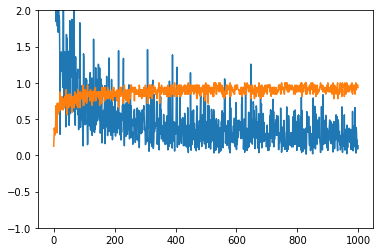

In [7]:
# Training

loss_function = nn.NLLLoss(reduction = 'none')
optim = torch.optim.SGD(model.parameters(), lr = 0.001,momentum=0)
losses, accuracies = [],[]
BS = 32
for i in trange(1000):
    samp = np.random.randint(0,X_train.shape[0], size = (BS))
    X = torch.tensor(X_train[samp].reshape(-1, 28*28)).float()
    Y = torch.tensor(Y_train[samp]).long()
    optim.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    
    accuracy = (cat==Y).float().mean()
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
plt.ylim(-1,2)
plt.plot(losses)
plt.plot(accuracies)

In [8]:
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()

In [9]:
(Y_test_preds == Y_test).mean()

0.9236

# Implement without Pytorch

In [10]:
l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)
l1[:] = model.l1.weight.detach().numpy().T
l2[:] = model.l2.weight.detach().numpy().T

#### It is called value death when you have lots of zeros


In [91]:
# Numpy forward pass
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x,0)
    x = x.dot(l2)
    return x

def numpy_eval():
    Y_test_preds_out = forward(X_test.reshape(-1, 28*28))
    Y_test_preds = np.argmax(Y_test_preds_out, axis = 1)
    return (Y_test == Y_test_preds).mean()

numpy_eval()

0.117

In [12]:
LogSoftMax = -1 * np.log(np.exp(Y_test_preds_out)/ np.exp(Y_test_preds_out).sum(axis = 1)[:, None])

In [13]:
ret = LogSoftMax[range(LogSoftMax.shape[0]), Y_test]

In [291]:
-Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis = 1))

array([0.        , 0.00001717, 0.00041771, ..., 0.01540184, 0.00242996,
       0.00003815], dtype=float32)

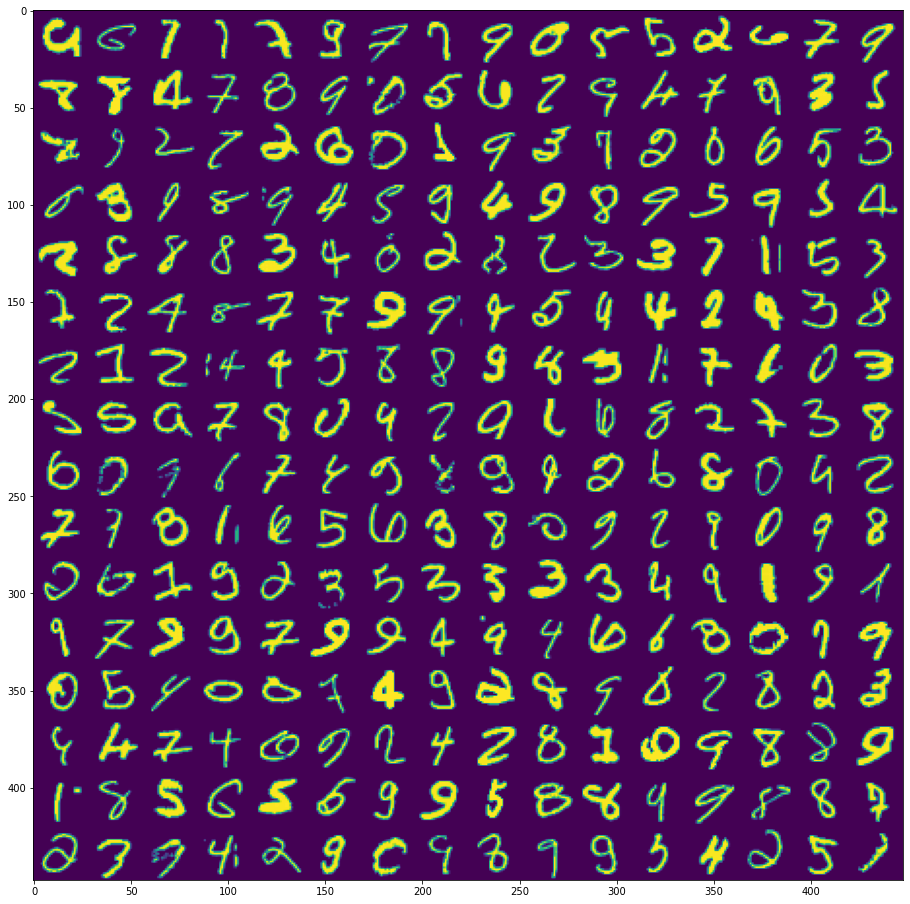

In [326]:
figsize(16,16)
G=16
X_bad = np.take(X_test, np.argsort(ret)[::-1][:G*G], axis = 0)
imshow(np.concatenate(X_bad.reshape(G,28*G,28), axis = 1))

# Do the derivative

(tensor(1.),
 tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0312,
           0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.0000, -0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [-0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -0.0312,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.0000, -0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -0.0312,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000, -0.0312],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0312,  0.0000,  0.0000,
           0.0000

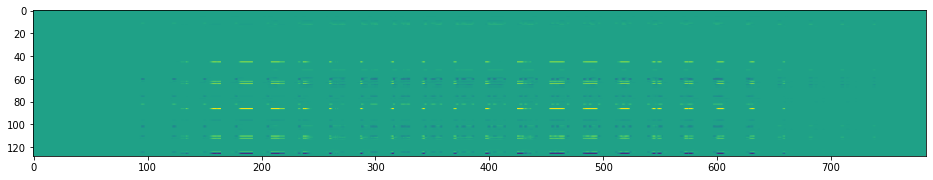

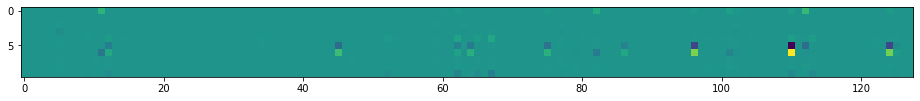

In [65]:
samp = list(range(32))

model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape(-1,28*28)).float())
out.retain_grad()
loss = loss_function(out,torch.tensor(Y_test[samp]).long())
loss = loss.mean()
loss.retain_grad()
loss.backward()
figsize(16,16)
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)

loss.grad, out.grad

In [15]:
# Derivative of logsoftmax
# Will involve x_l2, out, and produce dx_sm
#------------------------------------------------
# Cheating using pytorch LOL
#------------------------------------------------
# gin = torch.tensor(x_l2, requires_grad=True)
# gout = torch.nn.functional.log_softmax(gin, dim = 1)
# gout.retain_grad()
# out_tensor = torch.tensor(out)
# loss = (-out_tensor * gout).mean()
# loss.backward()
# dx_lsm = gin.grad.numpy()
#------------------------------------------------


array([0.00000008, 0.0003527 ])

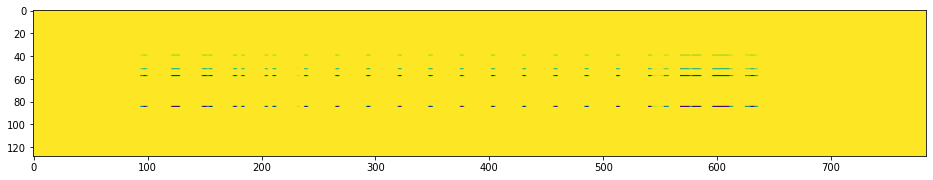

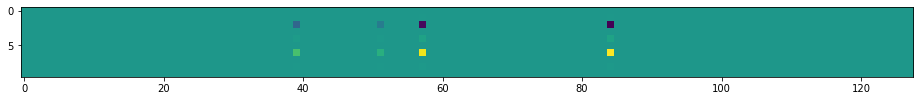

In [108]:
# Training
samp = list(range(32))


def logsumexp(x):
    # np.log(np.exp(x).sum(axis=1))
    c = np.max(x, axis = 1)
    return c + np.log(np.exp(x-c.reshape((-1,1))).sum(axis=1))

def forward_backward(X,Y):
    """
    Numpy forward and backward pass
    """
    
    
    # AlexNet Forward Pass
    # Out: Output of the system
    # x_lsm = Loss after passing through the logsoftmax (gout in pytorch)
    # x_l2 : X after passing through layer 2 (gin in pytorch)
    # x_relu: X after passing through relu layer
    # x_l1 : X after passing through layer 1
    # x : Input after reshaping


    # Get the derivative of the input with respect to the output
    # Doing back propagation
    out = np.zeros((len(Y),10), np.float32)
    out[range(out.shape[0]), Y] = 1

    # Forward pass
    x_l1 = X.dot(l1)
    x_relu = np.maximum(x_l1, 0)
    x_l2 = x_relu.dot(l2)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1,1))
    x_loss = (-out * x_lsm).mean(axis = 1)


    # AlexNet backward Pass
    # dx_sm: Gradient of Softmax function
    # d_l2: Gradient of l2 layer
    # d_l1: Gradient of l1 layer
    # dx_relu: Gradient of relu layer
    # d_out: Gradient of the output
    # dx_loss: Gradient of the loss

    dx_out = -out/len(Y)
    dx_lsm = dx_out - np.exp(x_lsm) * dx_out.sum(axis=1).reshape((-1,1))
    # Derivative of l2
    d_l2 = x_relu.T.dot(dx_lsm)
    dx_relu = dx_lsm.dot(l2.T)
    # Derivative of RELU
    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu
    # Derivative of l1
    d_l1 = X.T.dot(dx_l1)
    return x_loss, x_l2, d_l1, d_l2 


    
    
samp = [0,1]
loss,x_l2, d_l1, d_l2 = forward_backward(X_test[samp].reshape((-1, 28*28)), Y_test[samp])

# Printing
figsize(16,16)
imshow(d_l1.T)
figure()

imshow(d_l2.T)
figsize(16,16)
loss

100%|██████████| 1000/1000 [00:01<00:00, 924.62it/s]


0.9635

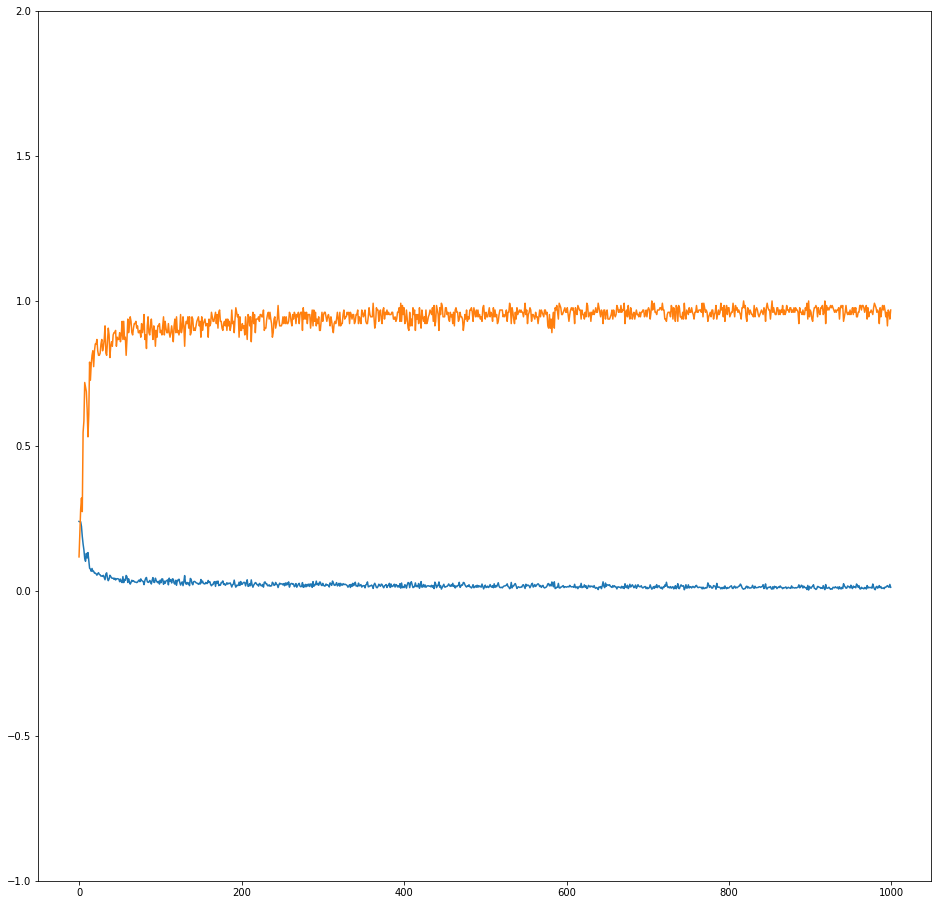

In [122]:
# Numpy Training
# def kaiming(m,h):
#     return np.random.normal(size = (m,h))* math.sqrt(2./m)

def layer_init(m,h):
    stdv = 1./np.sqrt(m*h)
    ret = np.random.uniform(-stdv, stdv, size = (m,h))
    return ret.astype(np.float32)

# Reinit
lr = 0.001
l1 = layer_init(784, 128)
l2 = layer_init(128, 10)


losses, accuracies = [],[]
BS = 128
for i in trange(1000):
    samp = np.random.randint(0,X_train.shape[0], size = (BS))
    X = X_train[samp].reshape((-1, 28*28))
    Y = Y_train[samp]
    x_loss, x_l2, d_l1, d_l2 = forward_backward(X,Y)
    cat = np.argmax(x_l2, axis= 1)
    
    loss = x_loss.mean()
    accuracy = (cat == Y).mean()
    
    losses.append(loss)
    accuracies.append(accuracy)
     
    # SGD
    l1 = l1 - d_l1* lr
    l2 = l2 - d_l2* lr
    
plt.ylim(-1,2)
plt.plot(losses)
plt.plot(accuracies)
numpy_eval()